In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
# Summary-like from Tensorflow
from torchsummary import summary
# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
from statistics import mean
# WFDB
import wfdb
# ==== LOCAL LIBS ====
import ecg_tools_lite as et
import trainer as tr
import models as mod

In [2]:
# =============== LOAD ECG DATA ===============

# Load the files
ecg_clean = np.load('all_none_fs1024_e24.npy')
ecg_noisy = np.load('all_none_fs1024_e12.npy')

# Push to CUDA
ecg_clean = torch.from_numpy(ecg_clean).cuda().double()
ecg_noisy = torch.from_numpy(ecg_noisy).cuda().double()

# Reshape for Torch format
ecg_clean = ecg_clean.view( (ecg_clean.shape[0], ecg_clean.shape[2], ecg_clean.shape[1]))
ecg_noisy = ecg_noisy.view( (ecg_noisy.shape[0], ecg_noisy.shape[2], ecg_noisy.shape[1]))

# Normalize ecg_clean per subset
ecg_clean = et.norm_sig(ecg_clean)
ecg_noisy = et.norm_sig(ecg_noisy)

In [3]:
run_new_model = False # Lazy run-all

if run_new_model:
    model = mod.ae_sampler().cuda()
    model.double()
    losses = tr.train_model( model=model,
                    epochs=2, 
                    ecg_noisy=ecg_noisy, 
                    ecg_clean=ecg_noisy,
                    train_pct=0.8)
else:
    model = mod.ae_sampler().cuda()
    model.double()
    model.load_state_dict(torch.load('saved_model_dict.pt'))
    model.to('cuda')
    model.eval()

In [4]:
# ==== FLATTEN ALL THE DATA ====
ecg_clean_flat = ecg_clean.flatten()
ecg_noisy_flat = ecg_noisy.flatten()

In [5]:
# Can only handle up to 4000 of the entire data set (then restart)
result = model.encoder( ecg_noisy[0:4000] )
result = model.decoder( result )
result = result.detach().cpu().numpy()
print( f'Result size: {result.shape}')
np.save('res_pt1', result) # ranges from 0:4000
# np.save('res_pt2', result) # ranges from 4001:5544

Result size: (4000, 1, 1024)


In [6]:
# pt1 = np.load('res_pt1.npy')
# pt2 = np.load('res_pt2.npy')

# pt_full = np.concatenate( (pt1, pt2) )
# pt_full.shape

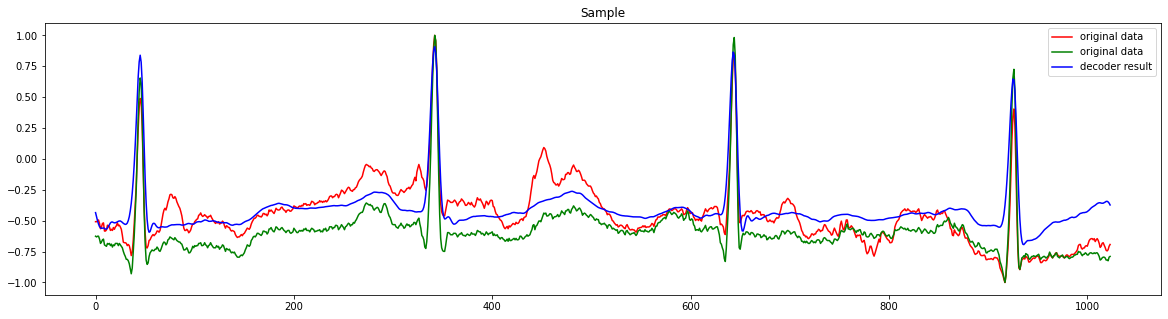

In [7]:
index = 0

plt.figure( figsize=(20,5) )
plt.plot( ecg_noisy[index][0].cpu(), c='red', label='original data' )
plt.plot( ecg_clean[index][0].cpu(), c='green', label='original data' )
plt.plot( result[index][0], c='blue', label='decoder result' )
plt.title(label='Sample')
plt.legend()
